In [368]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

### Общая информация
Дата выдачи: 24.05.2016

Срок сдачи: 23:59 31.05.2016

Максимальная оценка за задание: 10 баллов.

Пожалуйста, указывайте тему письма в формате «[ИАД-16] HW6, ФИО».

### Данные

С помощью решающих деревьев и случайных лесов мы будем оценивать качество вина. Csv-файл с данными доступен по [ссылке](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv).

Целевой признак — quality, так что нас ждёт задача мультиклассовой классификации.

#### Часть I. Готовим данные.

**1.** Загрузите данные и запишите их в датафрейм all_wine, выведите пять первых записей с помощью head. Узнайте, какие значения принимает целевой признак quality. Посмотрите, есть ли пропуски в данных?

In [369]:
all_wine = pd.read_csv('winequality-red.csv', sep=';')
all_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [370]:
print('Признак quality принимает следующие значения:', all_wine.quality.unique())
print('Проверяем есть ли пропуски в данных: ', all_wine.isnull().values.any())

Признак quality принимает следующие значения: [5 6 7 4 8 3]
Проверяем есть ли пропуски в данных:  False


**2.** Посчитайте число объектов каждого класса в выборке. Есть ли классы, в которых особенно мало объектов? Их можно удалить или объединить с «соседними» классами. Удалите объекты классов, объекты которых встречаются меньше 15 раз.

In [371]:
print('Количество объектов каждого класса в выборке:')
counted_values = all_wine['quality'].value_counts()
print(counted_values)

Количество объектов каждого класса в выборке:
5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64


In [372]:
# Getting all classes, where counted_values < 15
selected_values = dict(counted_values.where(counted_values < 15).dropna())
# Removing it from our dataframe
all_wine = all_wine[~all_wine.quality.isin(selected_values)];

**3.** Разбейте выборку в отношении 7 к 3 на train и test, предварительно перемешав. Матрицы объекты×признаки назовите X_train, X_test, а целевой вектор — y_train, y_test соответственно.

In [373]:
from sklearn.cross_validation import train_test_split

# Getting X and y values for future train, test split
X = all_wine.drop('quality', 1)
y = np.array(all_wine['quality'])

# Splitting it into test and train samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Часть II. Исследование параметров случайных лесов

**4.** Для начала обучите Random Forest с параметрами по умолчанию, посчитайте ошибку на тестовой выборке по F-мере (используйте average='weighted').

In [477]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Training our classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train);

# And gaining f1 score
predict = rf.predict(X_test)
f1_sc = f1_score(y_test, predict, average="weighted")

print('F1 score = ', f1_sc)

F1 score =  0.648249663202


C:\Users\bulga\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**5.** Постройте оценки важности признаков, попробуйте удалить самые неважные и проверить, улучшилось ли качество.

<a list of 11 Text xticklabel objects>

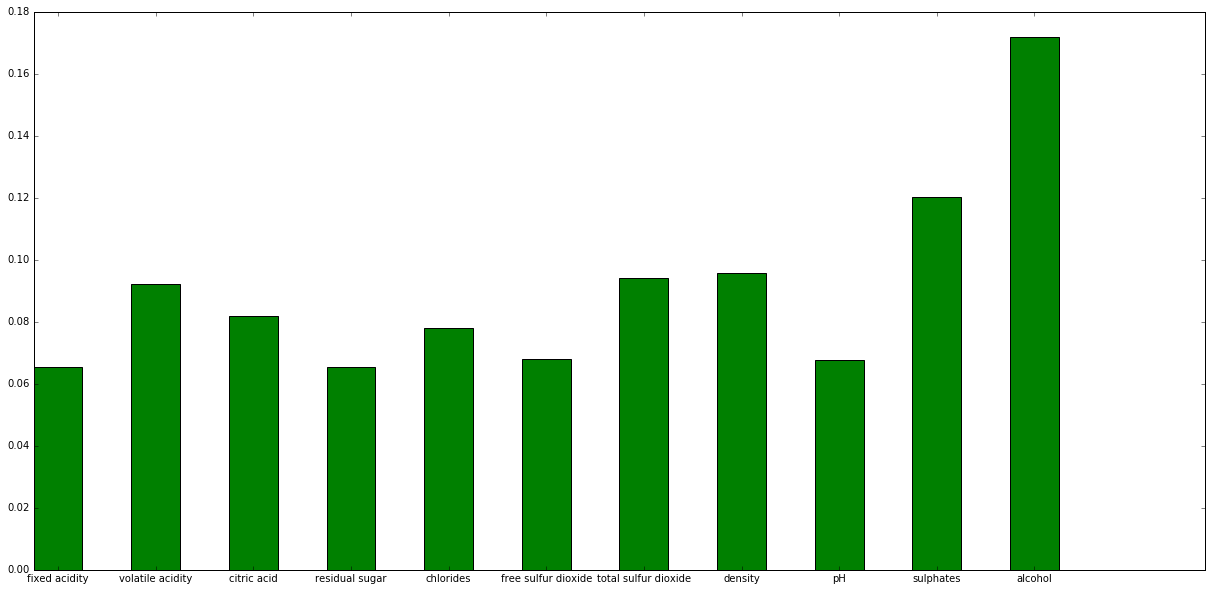

In [412]:
# Getting each feature importance and building a plot
importance = rf.feature_importances_
idx = np.arange(importance.size)
width = 0.5
plt.figure(figsize=(21,10))
p1 = plt.bar(idx, rf.feature_importances_, width, color='g')
plt.xticks(idx+width/2, X.columns.values)[1]

In [492]:
# Removing unnecessary features
selected_features = ['alcohol', 'volatile acidity', 'total sulfur dioxide', 'sulphates', 'density', 'chlorides']
X_train_s = X_train[selected_features]
X_test_s = X_test[selected_features]

# Training our classifier
rf = RandomForestClassifier()
rf.fit(X_train_s, y_train);

# And gaining f1 score
predict = rf.predict(X_test_s)
f1_sc = f1_score(y_test, predict, average="weighted")

print('F1 score = ', f1_sc)

F1 score =  0.640946842724


**6.** С помощью кросс-валидации подберите оптимальные значения параметров:

* criterion — критерий, используемый при построении деревьев ('gini' или 'entropy');
* max_features — мощность подмножества признаков, используемых при построении каждой вершины (переберите все возможные числовые значения);
* max_depth — максимальная глубина деревьев (переберите разумные значения по своему выбору); 
* class_weight — параметр, отвечающий за взвешивание классов (выберите из None или 'balanced');

Число деревьев пока установите равным 100.

Подобрав оптимальные параметры, постройте графики зависимости качества на тестовой выборке от max_features и max_depth при фиксированных значениях остальных параметров.

Какие параметры влияют на работу алгоритма наиболее существенно?

In [493]:
from sklearn.grid_search import GridSearchCV
parameters = {'criterion':['gini', 'entropy'], 'max_features':np.arange(1,6),'max_depth':[2, 4, 8, 16, 32], 
              'class_weight':[None, 'balanced']}
cv = GridSearchCV(RandomForestClassifier(), parameters)
cv.fit(X_train_s, y_train);
cv.best_score_

0.64298561151079137

**7.** Эмпирически установлено, что при увеличении числа деревьев качество не ухудшается. Проверим это утверждение. Постройте график зависимости качества на тестовой выборке от числа деревьев (n_estimators).

Вам нужно будет перебрать значения до 3000 деревьев (например, с шагом 10: 10, 20, 30, ..., 3000) посчитать качество на тестовой выборке и построить график.

Конечно, для этого можно каждый раз обучать RandomForest с нуля. Однако в таком случае придётся обучить в общей сумме $10 + 20 + \ldots + 3000 = 451500$ деревьев.

Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 3000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно будет указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

In [ ]:
# your code here

**8.** Проверьте, что результат работы RandomForest не зависит от нормировки признаков. Для этого отнормируйте каждый признак, обучите RF и сравните результаты.

In [ ]:
from sklearn.preprocessing import StandardScaler

# your code here

**9.** Сделайте выводы о том, насколько сильно выбор параметров влияет на работу случайных лесов. Ответьте на вопрос, какую существенную особенность данных мы не учли при построении алгоритма?